Gerekli kütüphanler

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report


dosyayı yükleme

In [3]:
df = pd.read_csv("/content/UNSW_NB15_training-set.csv")

ilk 5 satır

In [4]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


Nan değer kontrolü

In [5]:
df.isna().sum()

,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

sadece numeric columnları saklamak istiyoruz.

In [11]:
categorical_columns = df.select_dtypes(include=["object"]).columns.tolist()
categorical_columns.remove("attack_cat")

In [12]:
categorical_columns

['proto', 'service', 'state']

In [13]:
numberic_col_df = df.drop(columns=categorical_columns)

In [15]:
numberic_col_df.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,2,0,1068,0,200000.0051,254,0,854400000.0,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,2,0,900,0,166666.6608,254,0,600000000.0,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,2,0,2126,0,100000.0025,254,0,850400000.0,...,1,3,0,0,0,2,3,0,Normal,0


In [24]:
numberic_col_df["attack_cat"].unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [18]:
print("label = 0 ", len(numberic_col_df[numberic_col_df["label"] == 0]))
print("label = 1 ", len(numberic_col_df[numberic_col_df["label"] == 1]))


label = 0  37000
label = 1  45332


önce veri setini ayarlıyoruz.

In [23]:
normal = numberic_col_df[numberic_col_df["label"] == 0].sample(2000, random_state=42)
attack = numberic_col_df[numberic_col_df["label"] == 1].sample(500, random_state=42)
df_sample = pd.concat([normal, attack]).sample(frac=1, random_state=42)

In [25]:
x = df_sample.drop(columns=["label", "id","attack_cat"])
y = df_sample["label"]

standartscale uyguluyorum.

In [26]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

DBSCAN

In [64]:
dbscan = DBSCAN(eps=1.3, min_samples=5)
db_preds = (dbscan.fit_predict(x_scaled) == -1).astype(int)

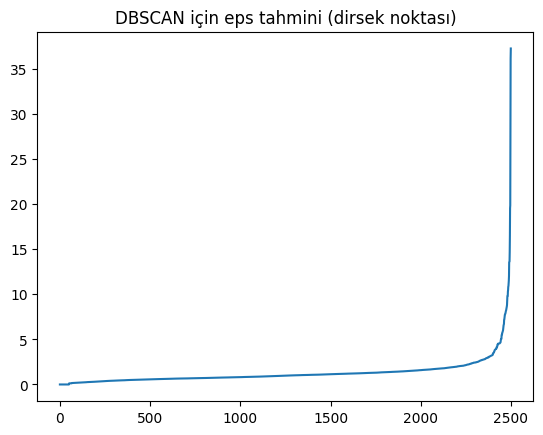

In [57]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(x_scaled)
distances, indices = neighbors_fit.kneighbors(x_scaled)

# En yakın komşuluk mesafesini çiz
distances = np.sort(distances[:,4])
plt.plot(distances)
plt.title("DBSCAN için eps tahmini (dirsek noktası)")
plt.show()

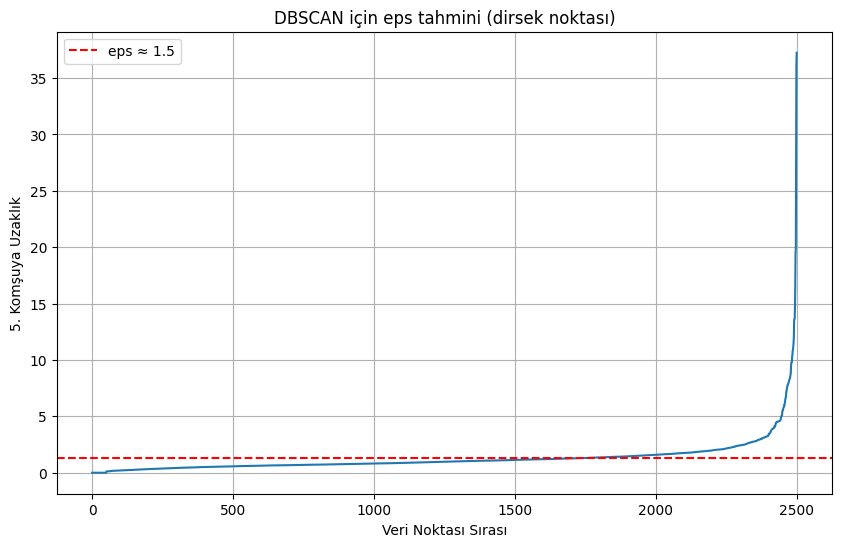

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=1.3, color='r', linestyle='--', label='eps ≈ 1.5')
plt.title("DBSCAN için eps tahmini (dirsek noktası)")
plt.xlabel("Veri Noktası Sırası")
plt.ylabel("5. Komşuya Uzaklık")
plt.legend()
plt.grid(True)
plt.show()

PCA ile görselleştirme

In [41]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_scaled)

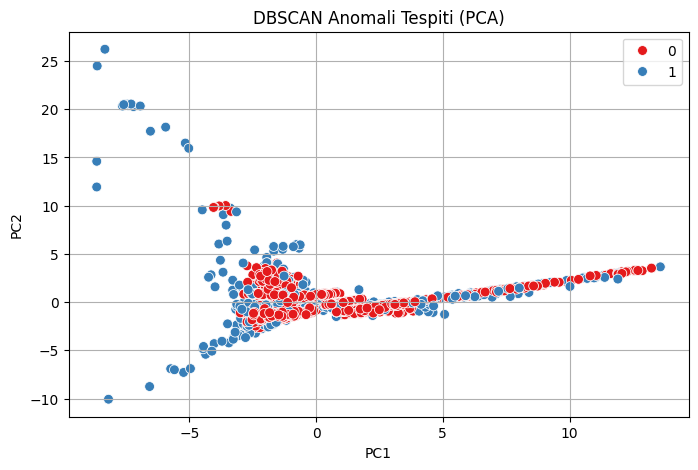

In [42]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_preds, palette="Set1", s=50)
plt.title("DBSCAN Anomali Tespiti (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

Isolation Forest

In [46]:
iso_model = IsolationForest(contamination=0.2, random_state=42)
iso_preds = (iso_model.fit_predict(x_scaled) == -1).astype(int)

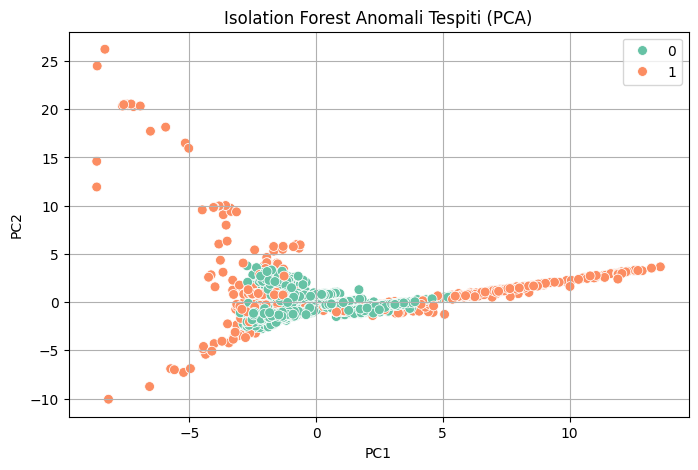

In [47]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=iso_preds, palette="Set2", s=50)
plt.title("Isolation Forest Anomali Tespiti (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [65]:
print("-------------------------DBSCAN------------------------")
print(confusion_matrix(y, db_preds))
print(classification_report(y, db_preds))
print("\n-------------------Isolation Forest-------------------")
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

-------------------------DBSCAN------------------------
[[1594  406]
 [ 364  136]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      2000
           1       0.25      0.27      0.26       500

    accuracy                           0.69      2500
   macro avg       0.53      0.53      0.53      2500
weighted avg       0.70      0.69      0.70      2500


-------------------Isolation Forest-------------------
[[1660  340]
 [ 340  160]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2000
           1       0.32      0.32      0.32       500

    accuracy                           0.73      2500
   macro avg       0.57      0.57      0.57      2500
weighted avg       0.73      0.73      0.73      2500



- eps 1.5 = recall = 0.22
- eps 1.4 recall = 0.25
- eps 1.3 recall =0.27